# Multi-step forecasting

## Direct approach

- We will predict the hourly pollutant concentration for the next 24 hours. 
- That is, we will forecast 24 steps ahead (multi-step forecasting).

## Recursive approach

- We will carry out multi-step forecasting using a recursive approach.
- We will now automate the process and make predictions for various points in the test set.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# Same function we saw in section 2.

def load_data():

    # Data lives here.
    filename = "../../Datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor", "RH"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

# Load data.

data = load_data()

data.head()

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


# Visualize the time-series

/Users/bach/.miniconda3/envs/feat-eng-ts/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


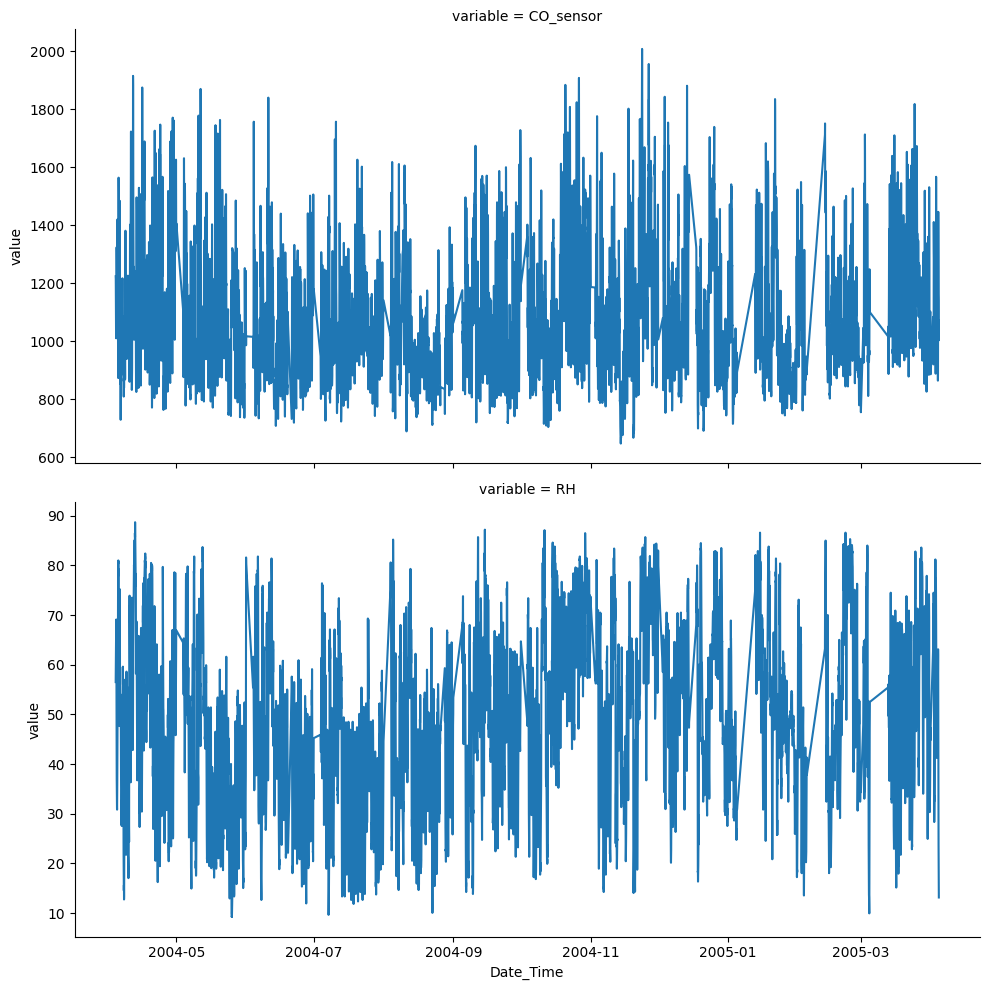

In [8]:
import seaborn as sns

sns.relplot(data.melt(ignore_index=False).reset_index(), x="Date_Time", y="value", col="variable", kind="line", facet_kws={"sharey": False}, aspect=2, col_wrap=1)

Any seasonal trends?

In [29]:
# Datetime features
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

/Users/bach/.miniconda3/envs/feat-eng-ts/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


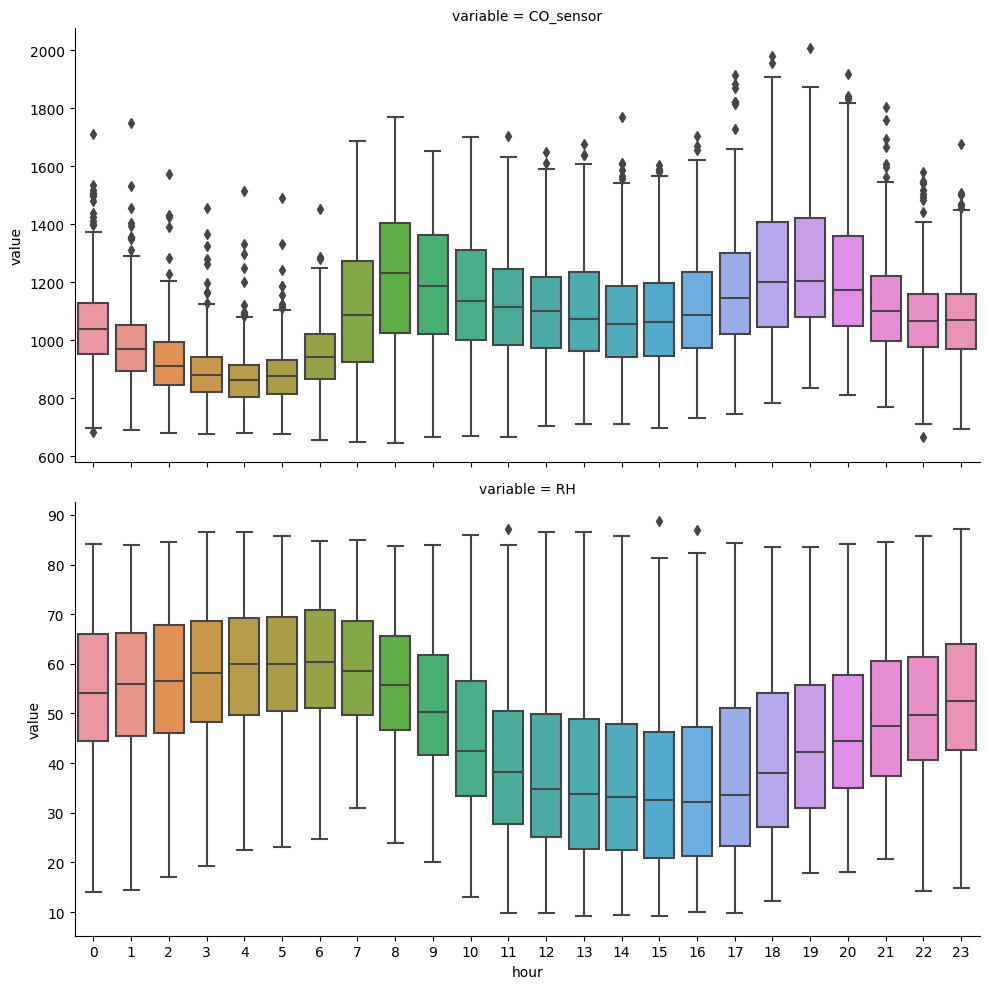

In [30]:
sns.catplot(
    (
        dtf
        .fit_transform(data)
        .melt(id_vars=["month", "hour"], value_vars=["CO_sensor", "RH"], ignore_index=False)
        .reset_index()
    ),
    x="hour", y="value", col="variable", kind="box", sharey=False , aspect=2, col_wrap=1
)

/Users/bach/.miniconda3/envs/feat-eng-ts/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


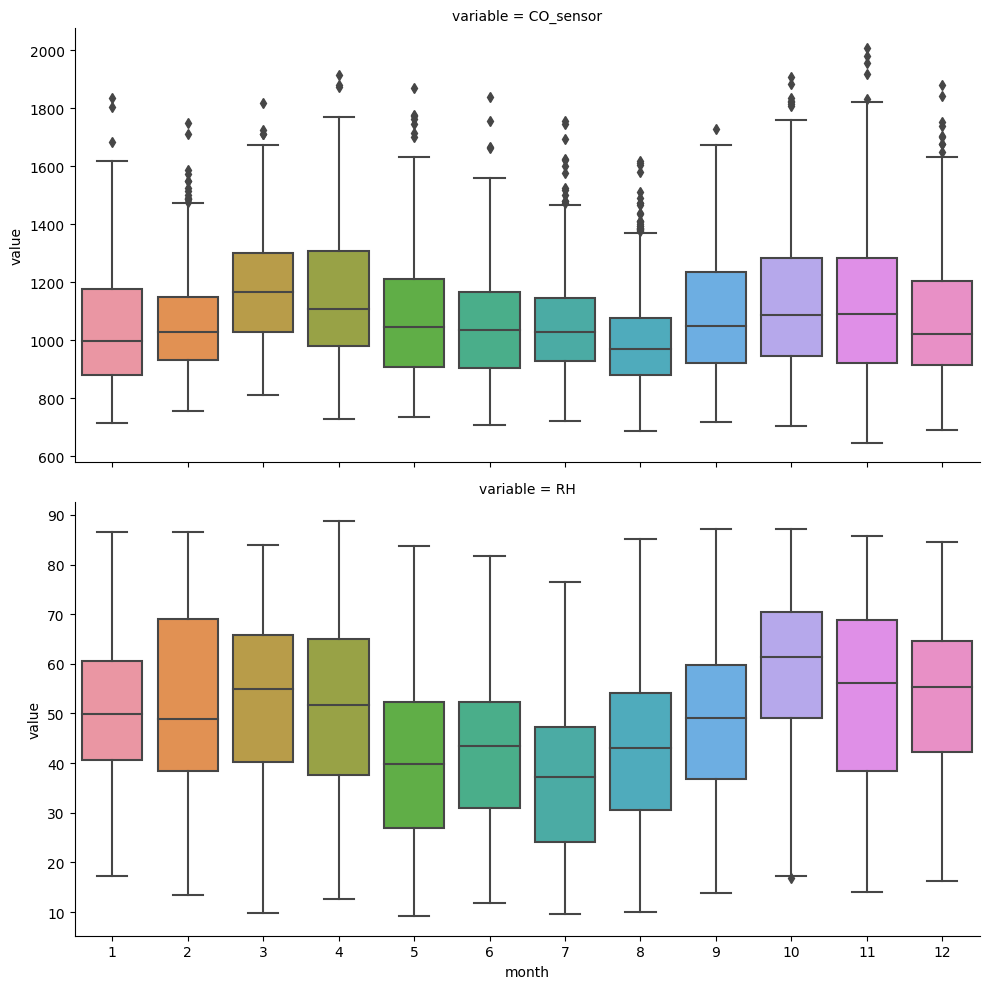

In [31]:
sns.catplot(
    (
        dtf
        .fit_transform(data)
        .melt(id_vars=["month", "hour"], value_vars=["CO_sensor", "RH"], ignore_index=False)
        .reset_index()
    ),
    x="month", y="value", col="variable", kind="box", sharey=False , aspect=2, col_wrap=1
)

# Feature engineering steps

The same pipeline from the previous notebook.

In [32]:
# Datetime features
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [33]:
# Lag features.

lagf = LagFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [34]:
# Window features

winf = WindowFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [35]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [36]:
# Drop missing data
imputer = DropMissingData()

In [37]:
# Drop original time series
drop_ts = DropFeatures(features_to_drop=["CO_sensor", "RH"])

# Feature engineering pipeline

In [38]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

# Evaluation parameters

In [141]:
# We make predictions every 24h for a horizon of 24h
prediction_period = 24
horizon = 24

# Training and test split date
split_date = "2005-03-04"

# Direct approach

## Split data into train and test

We will leave the last month of data as hold-out sample to evaluate the performance of the model.

Remember that we need data about the pollutant information at least 24 hours before the first forecasting point in the test set to create the input features.

In [142]:
# Split the data.
# input data
X_train = data[data.index < split_date]
X_test = data[data.index >= pd.Timestamp(split_date) - pd.offsets.Hour(24)]

# target
y_train = data[data.index < split_date]["CO_sensor"]
y_test = data[data.index >= pd.Timestamp(split_date) - pd.offsets.Hour(24)]["CO_sensor"]

## Prepare the target

In the direct approach, we build a model to predict each one of the steps in the forecasting horizon.

This means that we need to create suitable targets first:

- 1 hour ahead
- 2 hour ahead
- 3 hour ahead

...

- 24 hour ahead.

In [157]:
# Create an empty dataframe for the new targets.
y_train_multi = pd.DataFrame(index=y_train.index)
y_test_multi = pd.DataFrame(index=y_test.index)

# Add each one of the steps ahead.
for h in range(horizon):
    y_train_multi[f"h_{h}"] = y_train.shift(periods=-h, freq="H")
    y_test_multi[f"h_{h}"] = y_test.shift(periods=-h, freq="H")

In [144]:
# Each column represents one of the targets.
# Each target represents the number of steps ahead.
y_train_multi.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,1224.0,1215.0,1115.0,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,...,1136.0,1296.0,1345.0,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0
2004-04-04 01:00:00,1215.0,1115.0,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,...,1296.0,1345.0,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0
2004-04-04 02:00:00,1115.0,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,1268.0,...,1345.0,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0,999.0
2004-04-04 03:00:00,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,1268.0,1272.0,...,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0,999.0,911.0
2004-04-04 04:00:00,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,1268.0,1272.0,1160.0,...,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0,999.0,911.0,873.0


In [145]:
# Each column represents one of the targets.
# Each target represents the number of steps ahead.
y_test_multi.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-03 00:00:00,1047.0,1030.0,986.0,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,...,1096.0,1108.0,1124.0,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0
2005-03-03 01:00:00,1030.0,986.0,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,...,1108.0,1124.0,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,929.0
2005-03-03 02:00:00,986.0,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,1165.0,...,1124.0,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,929.0,951.0
2005-03-03 03:00:00,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,1165.0,1129.0,...,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,929.0,951.0,938.0
2005-03-03 04:00:00,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,1165.0,1129.0,1092.0,...,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,929.0,951.0,938.0,921.0


When we create our target, we will add some missing data because we obviously don't have all the information that far ahead.

In [146]:
y_train_multi.isnull().sum()

h_0       0
h_1      25
h_2      46
h_3      67
h_4      87
h_5     106
h_6     124
h_7     142
h_8     160
h_9     177
h_10    193
h_11    210
h_12    227
h_13    244
h_14    261
h_15    277
h_16    293
h_17    309
h_18    325
h_19    340
h_20    355
h_21    370
h_22    385
h_23    400
dtype: int64

In [147]:
y_test_multi.isnull().sum()

h_0      0
h_1      3
h_2      6
h_3      9
h_4     12
h_5     15
h_6     18
h_7     21
h_8     24
h_9     27
h_10    30
h_11    33
h_12    36
h_13    39
h_14    42
h_15    45
h_16    48
h_17    51
h_18    54
h_19    57
h_20    60
h_21    63
h_22    66
h_23    69
dtype: int64

In [148]:
# Let's drop the missing data points in the
# target and adjust our training and testing sets.

y_train_multi.dropna(inplace=True)
y_test_multi.dropna(inplace=True)

X_train = X_train.loc[y_train_multi.index]
X_test = X_test.loc[y_test_multi.index]

## Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [149]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,0,5,0,0,1188.0,60.8,1224.0,56.5,1165.666667,58.566667,0.866025,-0.5,0.000000,1.000000
2004-04-05 01:00:00,4,15,0,5,1,0,1065.0,65.8,1215.0,59.2,1149.666667,61.800000,0.866025,-0.5,0.269797,0.962917
2004-04-05 02:00:00,4,15,0,5,2,0,999.0,79.2,1115.0,62.4,1084.000000,68.600000,0.866025,-0.5,0.519584,0.854419
2004-04-05 03:00:00,4,15,0,5,3,0,911.0,80.0,1124.0,65.0,991.666667,75.000000,0.866025,-0.5,0.730836,0.682553
2004-04-05 04:00:00,4,15,0,5,4,0,873.0,81.0,1028.0,65.3,927.666667,80.066667,0.866025,-0.5,0.887885,0.460065


In [150]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train_multi.loc[X_train_t.index]

print(y_train_t.shape)

(6850,)
(5769, 24)


In [151]:
# Lasso regression

# Using the MultiOutputRegressor, we automatically create
# one Lasso for each target.

lasso = MultiOutputRegressor(Lasso(random_state=0, max_iter=50000))

# Train the model

lasso.fit(X_train_t, y_train_t)

MultiOutputRegressor(estimator=Lasso(max_iter=50000, random_state=0))

In [152]:
# Make predictions

y_train_t_pred = lasso.predict(X_train_t)

# The predictions are made for each one of
# the targets.

y_train_t_pred.shape

(5769, 24)

In [153]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.

y_train_t_pred = pd.DataFrame(y_train_t_pred, columns=y_train_t.columns, index=X_train_t.index)

y_train_t_pred.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-05 00:00:00,1152.872436,1081.938802,1029.199658,1014.221883,1035.531882,1086.727042,1156.940596,1209.156707,1187.625872,1113.841140,...,1171.163151,1222.690845,1258.088085,1275.446127,1249.578876,1187.135133,1110.832260,1060.559396,1059.902412,1073.437260
2004-04-05 01:00:00,1033.061791,1005.752976,994.984547,1007.313915,1040.868570,1092.116576,1150.991837,1198.213017,1190.904396,1142.782125,...,1179.051657,1213.942910,1246.817845,1265.117799,1244.370161,1195.767090,1133.632159,1078.454911,1035.317076,999.426732
2004-04-05 02:00:00,986.427271,998.418563,1027.787380,1063.779519,1097.559490,1127.269756,1151.036258,1175.398223,1177.356265,1156.166341,...,1213.078293,1236.129038,1259.667941,1267.646224,1235.737029,1171.396209,1092.081020,1027.252833,973.287504,929.599374
2004-04-05 03:00:00,923.659002,953.160610,983.997455,1013.942609,1043.834950,1075.318512,1105.415924,1135.631447,1150.884676,1149.101759,...,1177.103683,1177.648294,1176.717498,1164.577476,1128.638147,1078.567197,1022.824337,972.873320,927.830151,899.502782
2004-04-05 04:00:00,896.901441,935.173035,969.735974,998.731566,1025.928750,1055.121619,1084.698606,1113.331643,1136.144969,1148.864397,...,1145.480115,1128.390189,1106.499263,1078.811279,1042.035201,1003.797403,966.742024,931.722469,900.226307,886.962837


for horizon 0 got rmse: 93.06984159410605
for horizon 1 got rmse: 137.7071147109738
for horizon 2 got rmse: 161.83665951860286
for horizon 3 got rmse: 173.51942479499303
for horizon 4 got rmse: 177.79595984826702
for horizon 5 got rmse: 176.71573064553425
for horizon 6 got rmse: 170.5539534238455
for horizon 7 got rmse: 164.85136115957522
for horizon 8 got rmse: 171.05824654779553
for horizon 9 got rmse: 175.63551243070995
for horizon 10 got rmse: 174.09252789886924
for horizon 11 got rmse: 173.0303048783281
for horizon 12 got rmse: 175.65484036858226
for horizon 13 got rmse: 180.10117818062966
for horizon 14 got rmse: 184.00434982545784
for horizon 15 got rmse: 186.12551746706984
for horizon 16 got rmse: 185.298737495326
for horizon 17 got rmse: 182.36123729688885
for horizon 18 got rmse: 181.44720027346978
for horizon 19 got rmse: 181.22925925148732
for horizon 20 got rmse: 176.69406874062366
for horizon 21 got rmse: 171.0774974569061
for horizon 22 got rmse: 170.95832399978192
for h

Text(0, 0.5, 'RMSE')

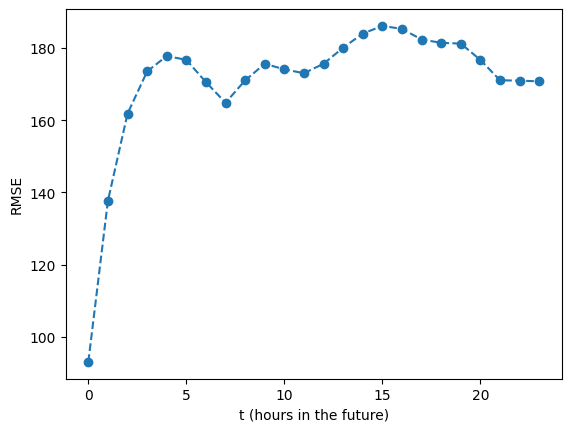

In [154]:
# The RMSE in the train set.
rmses = []

for h in range(horizon):
    rmses.append(mean_squared_error(y_train_t_pred[f"h_{h}"], y_train_t[f"h_{h}"], squared=False))
    print(f"for horizon {h} got rmse: {rmses[-1]}")

plt.plot(rmses, linestyle="--")
plt.scatter(np.arange(0, len(rmses)), rmses)
plt.xlabel("t (hours in the future)")
plt.ylabel("RMSE")

Notice how the RMSE is worse for those values further into the future. This is normal; predictions about the furthest values in the future always have a greater uncertainty.

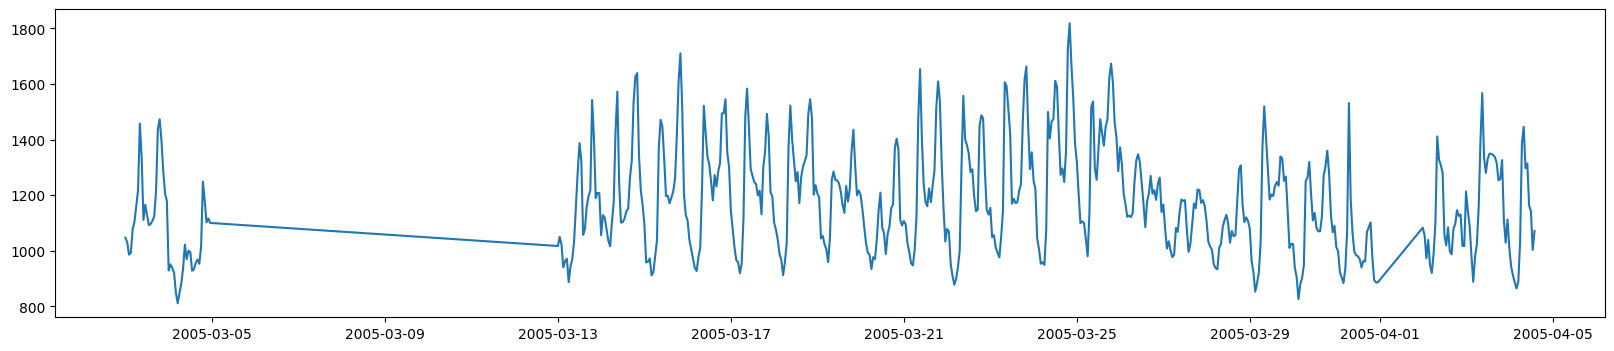

In [155]:
plt.figure(figsize=(20, 4))
plt.plot(y_test)

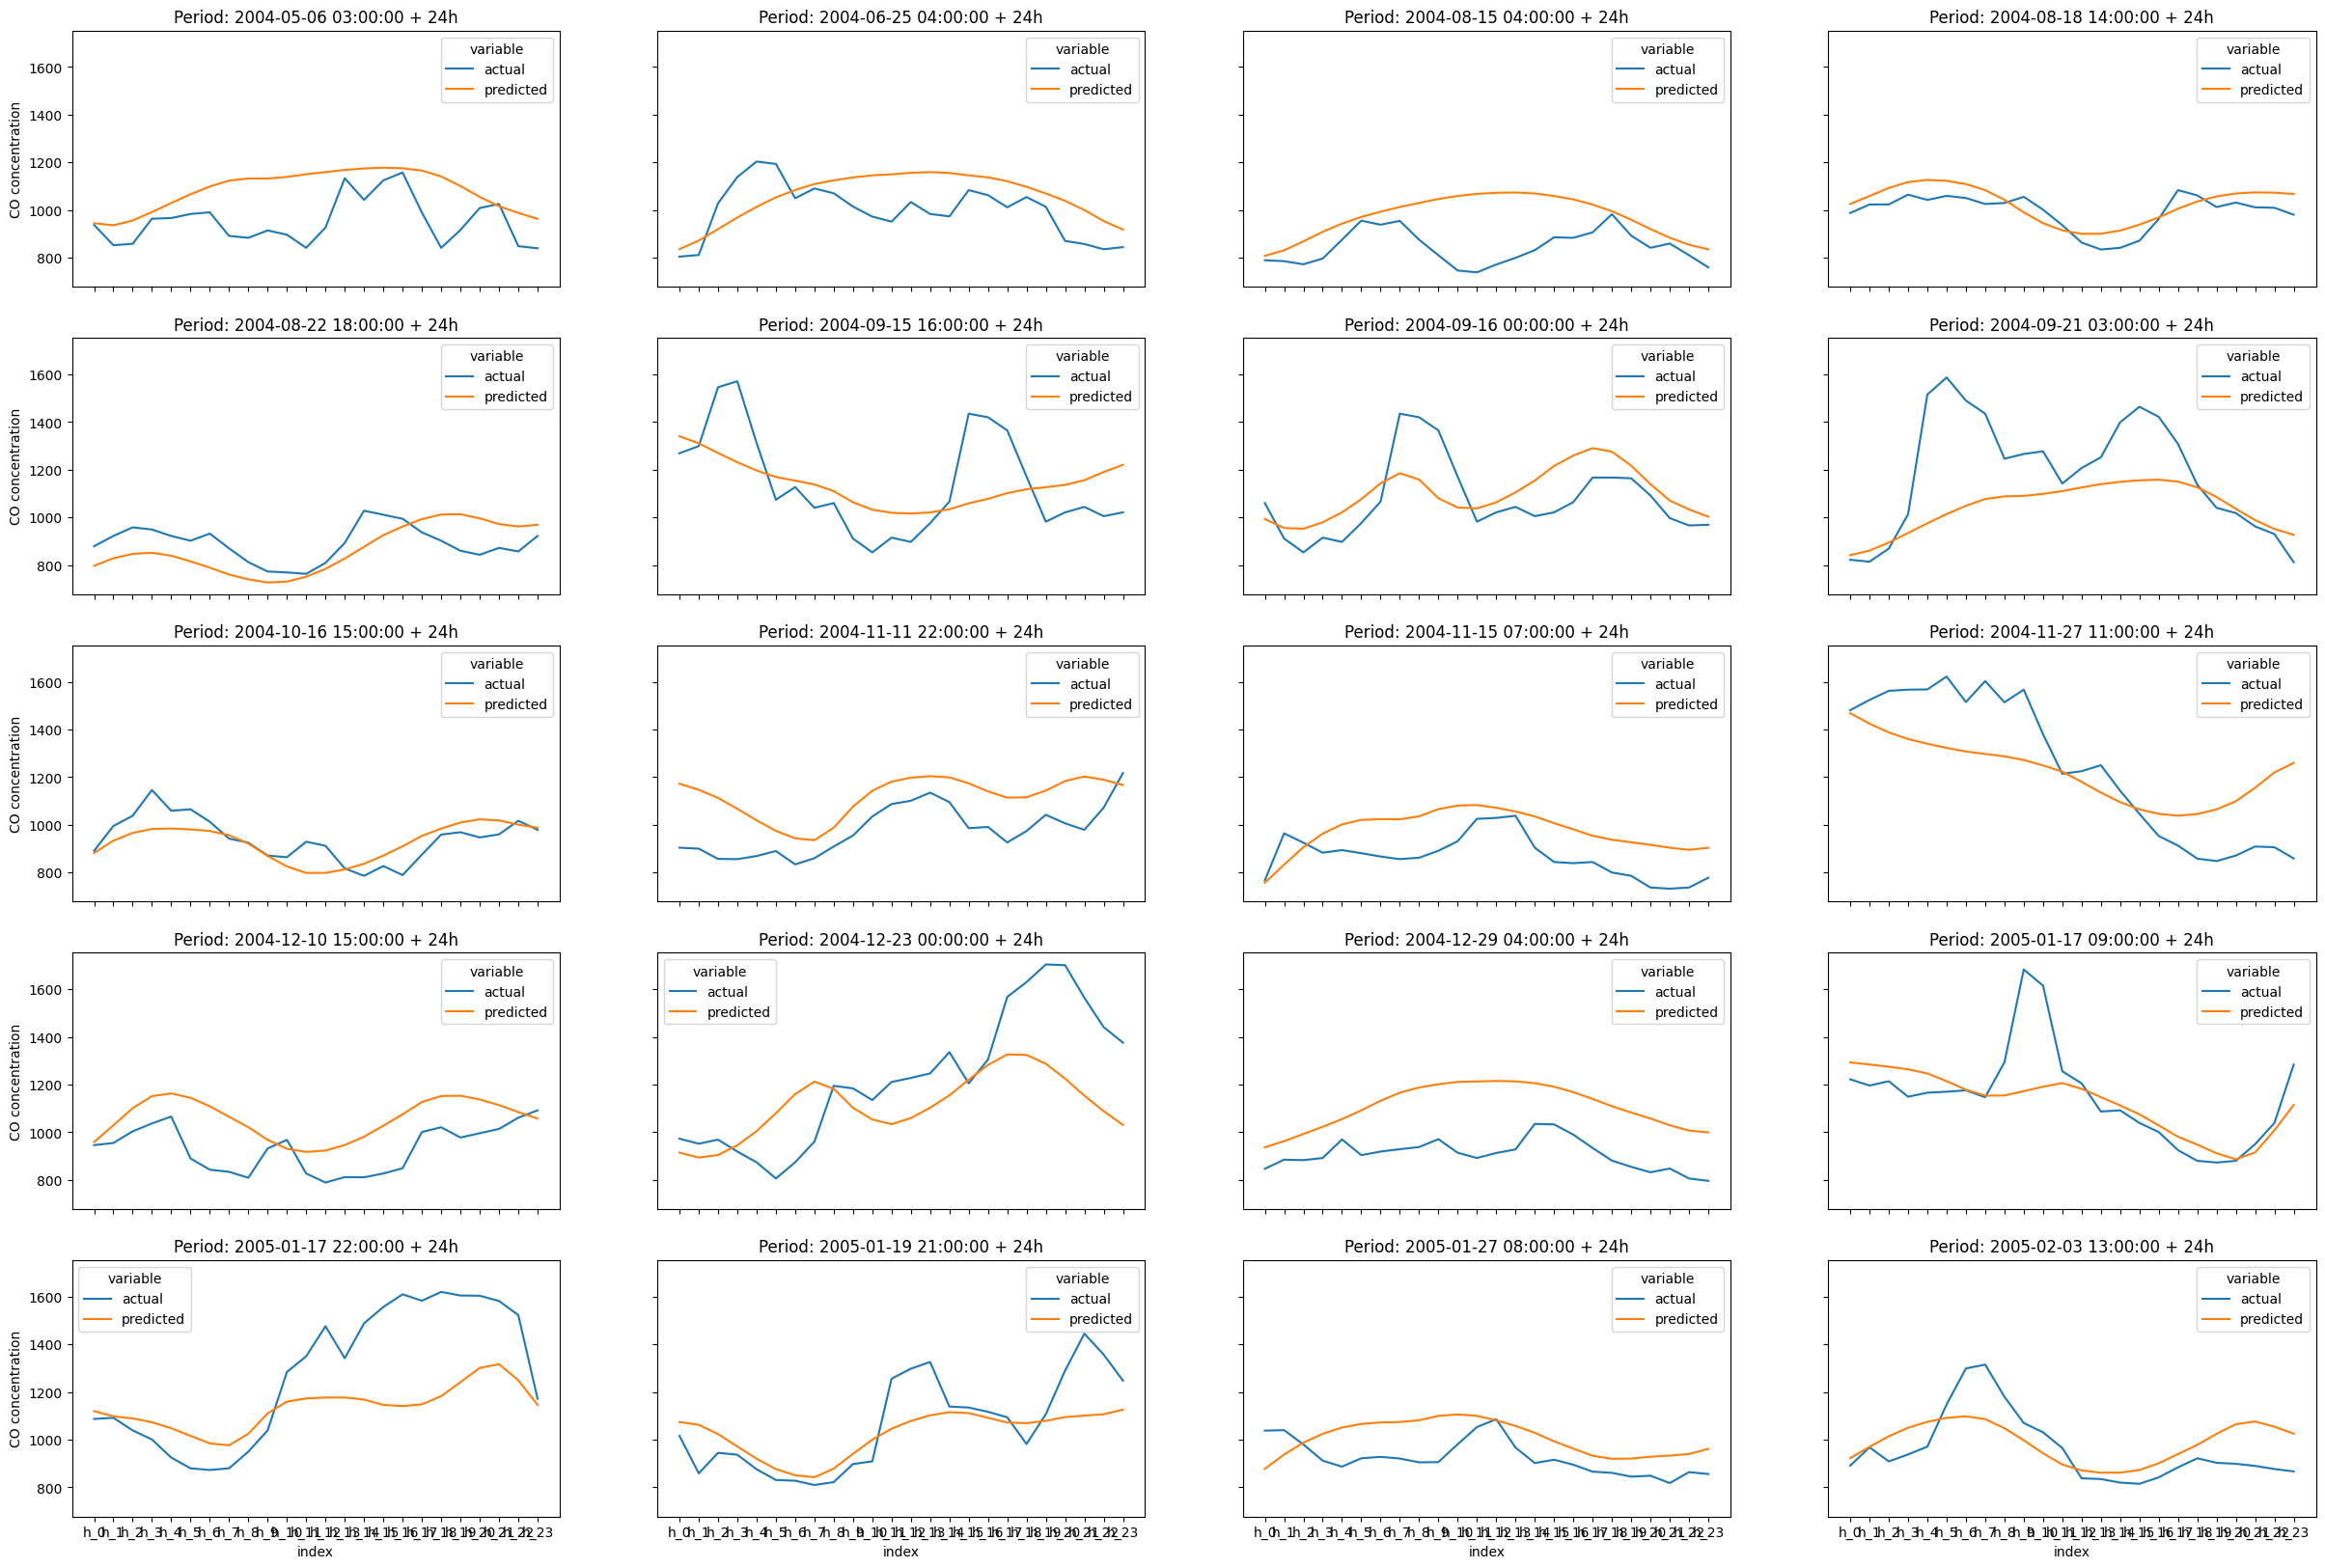

In [156]:
def plot_true_vs_pred(y: pd.DataFrame, y_pred: pd.DataFrame, n_plots_max: int = 20):
    n_cols = 4
    n_plots = np.minimum(len(y), n_plots_max)

    # Get the random subset for visualisation
    assert all(y.index == y_pred.index)
    y_spl = y.sample(n=n_plots, replace=False, random_state=101).sort_index()
    y_pred_spl = y_pred.loc[y_spl.index]

    fig, axrr = plt.subplots(nrows=n_plots_max // n_cols, ncols=n_cols, figsize=(30, 20), sharex=True, sharey=True)
    for i in range(n_plots):
        r, c = np.unravel_index(i, axrr.shape)
        ax = axrr[r, c]

        # Prepare dataframe for plotting
        tmp = pd.concat(
            [
                y_spl.iloc[i].T,
                y_pred_spl.iloc[i].T,
            ],
            axis=1,
        )

        tmp.columns = ["actual", "predicted"]

        sns.lineplot(tmp.reset_index().melt(id_vars="index"), y="value", x="index", hue="variable", ax=ax)

        ax.set_title(f"Period: {y_spl.index[i]} + 24h")
        ax.set_ylabel("CO concentration")

plot_true_vs_pred(y_train_t, y_train_t_pred)

Our model managed to get the trend of the forecast, but deviates from the real values quite a bit.

Hopefully, by the end of the course we can improve this model with more useful features :)

## Forecast 24 hours ahead in test set

We will evaluate the performance of the model in our test set now. 

**For the test set we apply our forecasting algorithm only at regular intervals**

In [160]:
l_ts_eval = pd.date_range(y_test.index.min(), y_test.index.max(), freq=f"{prediction_period}H")
# For the test set we apply our forecasting algorithm only at regular intervals:
# y_test_multi = y_test_multi[y_test_multi.index.isin(pd.date_range(y_test.index.min(), y_test.index.max(), freq=f"{prediction_period}H"))]

In [161]:
# Create the input features:
X_test_t = pipe.transform(X_test)
X_test_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2005-03-04 00:00:00,3,9,4,4,0,0,1179.0,82.0,1047.0,41.7,1223.333333,82.700000,1.0,6.123234e-17,0.000000,1.000000
2005-03-14 00:00:00,3,11,0,14,0,0,1207.0,55.6,1017.0,55.4,1201.333333,53.100000,1.0,6.123234e-17,0.000000,1.000000
2005-03-14 01:00:00,3,11,0,14,1,0,1056.0,55.9,1050.0,56.0,1157.000000,54.533333,1.0,6.123234e-17,0.269797,0.962917
2005-03-14 02:00:00,3,11,0,14,2,0,1128.0,62.1,1023.0,53.4,1130.333333,57.866667,1.0,6.123234e-17,0.519584,0.854419
2005-03-14 03:00:00,3,11,0,14,3,0,1119.0,68.9,940.0,51.8,1101.000000,62.300000,1.0,6.123234e-17,0.730836,0.682553


In [165]:
# Make predictions
y_test_t_preds = pd.DataFrame(lasso.predict(X_test_t), index=X_test_t.index, columns=y_test_multi.columns)
y_test_t_preds[y_test_t_preds.index.isin(l_ts_eval)]

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-04,1122.867321,1062.455291,1032.853059,1040.337108,1074.203578,1135.978334,1217.991003,1274.954502,1248.148873,1160.467624,...,1151.019588,1201.242335,1234.625491,1255.133049,1235.501115,1187.870324,1125.787999,1068.568355,1034.323715,1006.808840
2005-03-14,1141.110779,1064.348042,1025.341192,1027.799335,1060.734918,1115.861969,1185.090781,1233.090141,1208.189613,1133.941962,...,1180.865113,1236.786773,1280.156083,1308.891837,1296.820311,1245.681729,1175.977451,1125.091503,1111.759979,1100.308906
2005-03-15,1095.075100,1041.698591,1029.739241,1053.011638,1096.421335,1154.292240,1219.012997,1263.720918,1236.701392,1158.315141,...,1190.415275,1249.499545,1304.925154,1346.247910,1339.963767,1292.523337,1222.672945,1160.254394,1112.719108,1061.145681
2005-03-16,1035.663071,985.396382,982.404148,1016.660624,1072.898920,1145.147546,1221.796038,1272.958731,1245.856253,1165.132867,...,1177.523206,1236.583618,1301.323676,1356.126788,1365.372185,1339.074082,1290.382964,1230.156115,1158.481900,1071.555995
2005-03-17,1185.630628,1100.033860,1070.441583,1088.556844,1136.199108,1202.712056,1275.375984,1325.544335,1297.009142,1217.563351,...,1221.081848,1276.311882,1336.856993,1386.526910,1393.842904,1365.540069,1317.602297,1269.170919,1219.393207,1148.082286
2005-03-18,1119.749584,1057.014623,1035.343780,1054.081031,1098.912452,1161.544055,1230.296988,1278.567867,1248.560928,1169.001097,...,1203.020339,1260.884728,1319.280653,1360.556994,1355.148113,1311.995989,1248.023223,1188.787687,1141.939698,1090.360280
2005-03-19,1146.106179,1073.353529,1052.238653,1071.193339,1109.172385,1157.949973,1210.824414,1249.577445,1222.077223,1146.536519,...,1174.675837,1234.062556,1294.001428,1338.701855,1334.037449,1284.361974,1210.243769,1150.907920,1106.663477,1049.219104
2005-03-20,1142.040213,1054.355272,1003.485053,997.103588,1025.574086,1083.043248,1159.324918,1214.105385,1192.082672,1116.378552,...,1147.133964,1199.030101,1240.426628,1268.824066,1258.834416,1216.678612,1159.668407,1114.764213,1098.158095,1077.977572
2005-03-21,1046.543663,1008.760131,995.735245,1012.453574,1053.430527,1115.358742,1188.283208,1240.853273,1218.270144,1140.734896,...,1180.520692,1238.021630,1291.864769,1330.383193,1321.304022,1275.305037,1208.734129,1145.566320,1096.626091,1052.135813


In [ ]:
print(y_test_multi.shape)

# Adjust the target, it has observations
# that were removed from the test set due
# to null values.

y_test_t = y_test_multi.loc[X_test_t.index]

print(y_test_t.shape)

In [ ]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.

preds = pd.DataFrame(preds, columns=y_test_t.columns)

preds.head()

In [ ]:
# The RMSE in the test set.

for h in range(horizon):
    rmse = mean_squared_error(preds[f"h_{h}"], y_test_t[f"h_{h}"], squared=False)
    print(f"for horizon {h} got rmse: {rmse}")

In [ ]:
# Let's plot the first ten multistep forecasts
# in the train set.

# Each row corresponds to 24 hr forecasts.

for i in range(0, 10):
    tmp = pd.concat(
        [
            preds.iloc[i].T,
            y_test_t.iloc[i].T,
        ],
        axis=1,
    )

    tmp.columns = ["predicted", "actual"]

    tmp.plot()
    plt.ylabel("CO concentration")
    plt.show()

We've seen how to implement the direct forecasting method to perform multistep forecasting.